IMPORT LIBRARIES AND DATASET

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import pickle

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Time Series Libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load the dataset
df = pd.read_csv('/content/rwandan_household_energy.csv')

print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Sample data:")
print(df.head())

Dataset loaded successfully!
Dataset shape: (11000, 13)
Columns: ['Household_ID', 'Appliance', 'Power_Watts', 'Usage_Hours_Daily', 'Quantity', 'Usage_Days_Monthly', 'Region', 'Income_Level', 'Household_Size', 'Total_kWh_Monthly', 'Tariff_Bracket', 'Estimated_Bill_RWF', 'Month']
Sample data:
  Household_ID        Appliance  Power_Watts  Usage_Hours_Daily  Quantity  \
0      HH00001           Laptop           57                7.1         2   
1      HH00002             Iron         1041                4.4         3   
2      HH00003  Washing Machine          562                5.3         1   
3      HH00004     Water Heater         1804                3.5         1   
4      HH00005            Radio           44                6.7         1   

   Usage_Days_Monthly    Region Income_Level  Household_Size  \
0                  27   Eastern         High               1   
1                  23   Eastern         High               6   
2                  28   Eastern          Low         

EXPLORATORY DATA ANALYSIS AND PREPROCESSING

In [2]:
# Basic dataset info
print("Dataset Overview:")
print(f" Total records: {len(df):,}")
print(f"Unique households: {df['Household_ID'].nunique():,}")
print(f"Unique appliances: {df['Appliance'].nunique()}")
print(f" Regions: {df['Region'].unique().tolist()}")
print(f" Income levels: {df['Income_Level'].unique().tolist()}")
print(f" Months available: {sorted(df['Month'].unique())}")

# Check for missing values
print(f"\nMissing Values Analysis:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

# Data quality check
print(f"\nData Quality Check:")
print(f" Negative consumption values: {(df['Total_kWh_Monthly'] < 0).sum()}")
print(f" Zero consumption values: {(df['Total_kWh_Monthly'] == 0).sum()}")
print(f" Duplicate records: {df.duplicated().sum()}")

# Convert Month to proper datetime
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

df['Month_Num'] = df['Month'].map(month_mapping)
df['Year'] = 2024
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_Num'].astype(str) + '-01')

print(f"\nData preprocessing completed!")
print(f"Date range: {df['Date'].min().strftime('%Y-%m')} to {df['Date'].max().strftime('%Y-%m')}")

Dataset Overview:
 Total records: 11,000
Unique households: 11,000
Unique appliances: 12
 Regions: ['Eastern', 'Southern', 'Kigali', 'Northern', 'Western']
 Income levels: ['High', 'Low', 'Medium']
 Months available: ['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']

Missing Values Analysis:
Series([], dtype: int64)

Data Quality Check:
 Negative consumption values: 0
 Zero consumption values: 0
 Duplicate records: 0

Data preprocessing completed!
Date range: 2024-01 to 2024-12


DATA VISUALIZATION

Aggregated monthly data shape: (12, 6)

 Time Series Decomposition Analysis


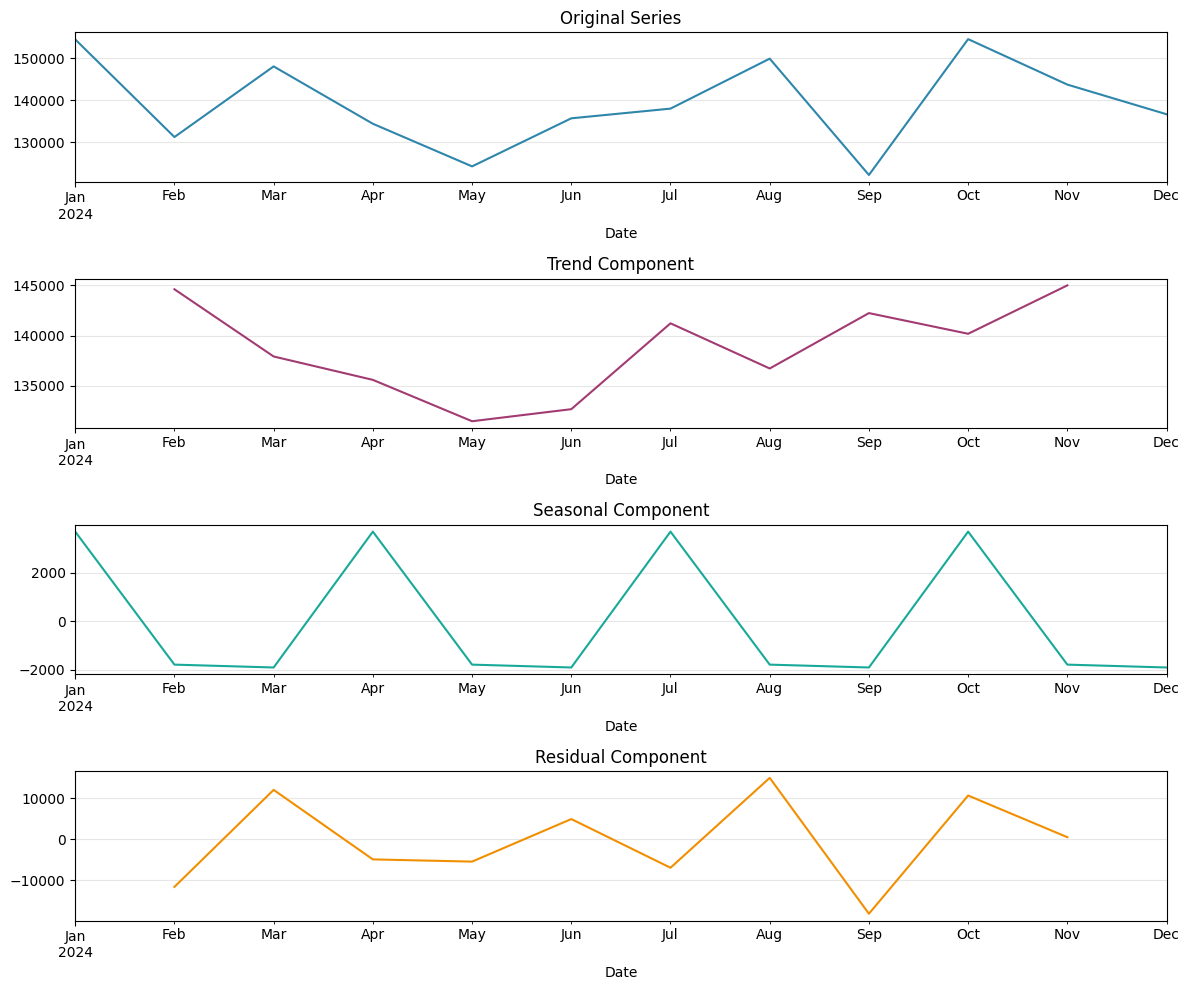

Data visualization completed!


In [4]:
# Set style
plt.style.use('default')
sns.set_palette("husl")

# Create monthly aggregated data
monthly_aggregate = df.groupby('Date').agg({
    'Total_kWh_Monthly': 'sum',
    'Estimated_Bill_RWF': 'sum',
    'Household_ID': 'count'
}).reset_index()

monthly_aggregate.columns = ['Date', 'Total_kWh', 'Total_Bill_RWF', 'Household_Count']
monthly_aggregate['Avg_kWh_per_Household'] = monthly_aggregate['Total_kWh'] / monthly_aggregate['Household_Count']
monthly_aggregate['Avg_Bill_per_Household'] = monthly_aggregate['Total_Bill_RWF'] / monthly_aggregate['Household_Count']

print(f"Aggregated monthly data shape: {monthly_aggregate.shape}")




# Time Series Decomposition
print("\n Time Series Decomposition Analysis")
ts_data = monthly_aggregate.set_index('Date')['Total_kWh']
decomposition = seasonal_decompose(ts_data, model='additive', period=3)

fig, axes = plt.subplots(4, 1, figsize=(12, 10))
decomposition.observed.plot(ax=axes[0], title='Original Series', color='#2E86AB')
decomposition.trend.plot(ax=axes[1], title='Trend Component', color='#A23B72')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component', color='#18A999')
decomposition.resid.plot(ax=axes[3], title='Residual Component', color='#F18F01')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Data visualization completed!")

DATA PREPROCESSING AND FEATURE ENGINEERING

In [12]:
# Create Individual Household Time Series
print("Creating individual household time series...")

# Pivot to get households as rows, months as columns
household_ts = df.pivot_table(
    index='Household_ID',
    columns='Month_Num',
    values='Total_kWh_Monthly',
    aggfunc='mean'
).reset_index()

# Add household metadata
household_meta = df.groupby('Household_ID').first().reset_index()[
    ['Household_ID', 'Region', 'Income_Level', 'Household_Size']
]
household_ts = pd.merge(household_ts, household_meta, on='Household_ID', how='left')

# Fill missing values with forward fill
month_cols = sorted([col for col in household_ts.columns if isinstance(col, (int, float))])
household_ts[month_cols] = household_ts[month_cols].ffill(axis=1).fillna(0)

print(f"Individual household time series shape: {household_ts.shape}")
print(f"Available months: {sorted(month_cols)}")

# Create sequences for time series forecasting
def create_household_sequences(household_data, lookback=3, forecast_horizon=2):
    sequences = []
    targets = []
    household_info = []

    month_columns = sorted([col for col in household_data.columns if isinstance(col, (int, float))])

    for idx, row in household_data.iterrows():
        household_id = row['Household_ID']
        region = row['Region']
        income_level = row['Income_Level']
        household_size = row['Household_Size']

        consumption_values = row[month_columns].values.astype(float)

        for i in range(lookback, len(consumption_values) - forecast_horizon + 1):
            if not np.isnan(consumption_values[i-lookback:i]).any():
                sequence = consumption_values[i-lookback:i]
                target = consumption_values[i:i+forecast_horizon]

                sequences.append(sequence)
                targets.append(target)
                household_info.append({
                    'household_id': household_id,
                    'region': region,
                    'income_level': income_level,
                    'household_size': household_size
                })

    return np.array(sequences), np.array(targets), household_info

# Create sequences
X_sequences, y_targets, household_info = create_household_sequences(household_ts, lookback=3, forecast_horizon=2)

print(f"\nSequences created successfully:")
print(f"• Input sequences (X): {X_sequences.shape} - (samples, lookback_months)")
print(f"• Target sequences (y): {y_targets.shape} - (samples, forecast_months)")
print(f"• Total training samples: {len(X_sequences)}")
print(f"• Sample input: {X_sequences[0]} → Target: {y_targets[0]}")

# Data scaling
print("\nScaling data for neural network...")
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_sequences.reshape(-1, 1)).reshape(X_sequences.shape)
y_scaled = scaler_y.fit_transform(y_targets.reshape(-1, 1)).reshape(y_targets.shape)

# Reshape for LSTM (samples, timesteps, features)
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

print("Feature engineering completed!")

Creating individual household time series...
Individual household time series shape: (11000, 16)
Available months: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Sequences created successfully:
• Input sequences (X): (88000, 3) - (samples, lookback_months)
• Target sequences (y): (88000, 2) - (samples, forecast_months)
• Total training samples: 88000
• Sample input: [ 0.    0.   21.85] → Target: [21.85 21.85]

Scaling data for neural network...
Feature engineering completed!


BUILD AND TRAIN THE NEURAL NETWORK MODEL

LSTM Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 3, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,554 (131.07 KB)

 Trainable params: 33,554 (131.07 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/150
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.0028 - mae: 0.0253 - mse: 0.0028 - val_loss: 0.0015 - val_mae: 0.0179 - val_mse: 0.0015
Epoch 2/150
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0015 - mae: 0.0168 - mse: 0.0015 - val_loss: 0.0016 - val_mae: 0.0165 - val_mse: 0.0016
Epoch 3/150
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0016 - mae: 0.0167 - mse: 0.0016 - val_loss: 0.0018 - val_mae: 0.0164 - val_mse: 0.0018
Epoch 4/150
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0015 - mae: 0.0163 - mse: 0.0015 - val_loss: 0.0016 - val_mae: 0.0155 - val_mse: 0.0016
Epoch 5/150
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0015 - mae: 0.0158 - mse: 0.0015 - val_loss: 0.0016 - val_mae: 0.0164 - val_mse: 0.0016
Epoch 6/150
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0015 - mae: 0.0159 - mse: 0.0015 - val_loss: 0.0017 - val_mae: 0.0167 - val_mse: 0.0017
Epoch 7/150
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/

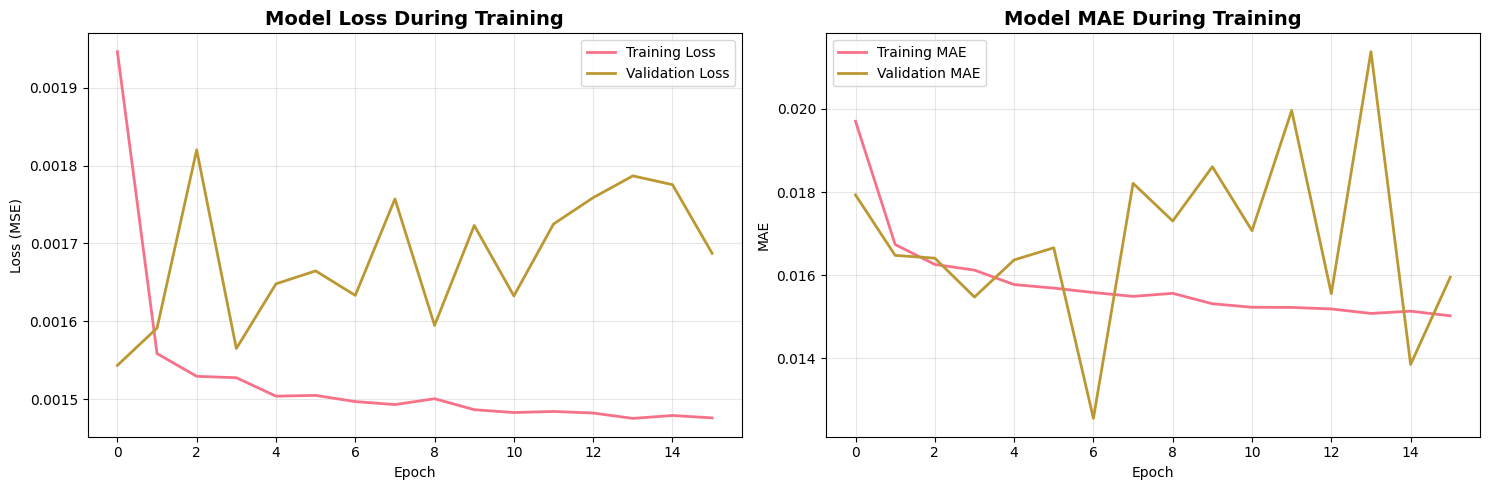

Model training completed!


In [13]:
# Build LSTM Model for Individual Household Forecasting
def build_household_lstm_model(lookback=3, forecast_horizon=2):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback, 1),
             kernel_initializer='glorot_uniform'),
        Dropout(0.3),
        LSTM(32, return_sequences=True,
             kernel_initializer='glorot_uniform'),
        Dropout(0.2),
        LSTM(16, return_sequences=False,
             kernel_initializer='glorot_uniform'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(forecast_horizon)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae', 'mse']
    )

    return model

# Build model
lstm_model = build_household_lstm_model(lookback=3, forecast_horizon=2)
print("LSTM Model Architecture:")
lstm_model.summary()

# Train the model
print("\nTraining LSTM model...")

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

history = lstm_model.fit(
    X_scaled, y_scaled,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1,
    shuffle=True
)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss During Training', fontsize=14, fontweight='bold')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.title('Model MAE During Training', fontsize=14, fontweight='bold')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Model training completed!")

MODEL EVALUATION

Evaluating model performance...

Model Performance by Forecast Month:
Month | MAE (kWh) | RMSE (kWh)
------------------------------
  1   |   37.50    |   85.59
  2   |   57.71    |   118.32

Overall Model Performance:
• Mean Absolute Error (MAE): 47.61 kWh
• Root Mean Squared Error (RMSE): 103.26 kWh
• Mean Actual Consumption: 101.04 kWh


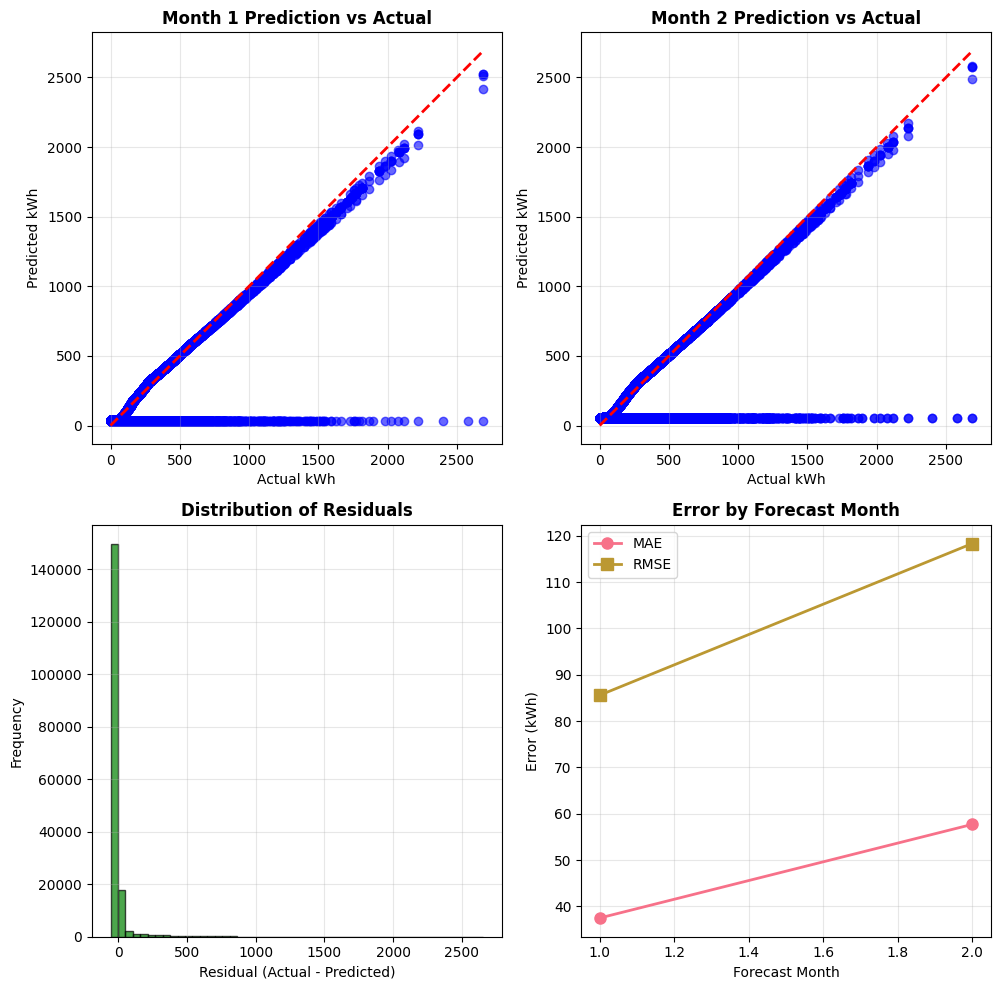

Model evaluation completed!


In [14]:
# Make predictions on training data
print("Evaluating model performance...")

train_predictions = lstm_model.predict(X_scaled, verbose=0)
train_predictions_rescaled = scaler_y.inverse_transform(train_predictions.reshape(-1, 1)).reshape(y_targets.shape)
y_actual_rescaled = scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).reshape(y_targets.shape)

# Calculate metrics
mae_scores = []
rmse_scores = []

for i in range(y_targets.shape[1]):
    mae = mean_absolute_error(y_actual_rescaled[:, i], train_predictions_rescaled[:, i])
    rmse = np.sqrt(mean_squared_error(y_actual_rescaled[:, i], train_predictions_rescaled[:, i]))
    mae_scores.append(mae)
    rmse_scores.append(rmse)

print("\nModel Performance by Forecast Month:")
print("Month | MAE (kWh) | RMSE (kWh)")
print("-" * 30)
for i, (mae, rmse) in enumerate(zip(mae_scores, rmse_scores)):
    print(f"  {i+1}   |   {mae:.2f}    |   {rmse:.2f}")

# Overall performance
overall_mae = mean_absolute_error(y_actual_rescaled.flatten(), train_predictions_rescaled.flatten())
overall_rmse = np.sqrt(mean_squared_error(y_actual_rescaled.flatten(), train_predictions_rescaled.flatten()))

print(f"\nOverall Model Performance:")
print(f"• Mean Absolute Error (MAE): {overall_mae:.2f} kWh")
print(f"• Root Mean Squared Error (RMSE): {overall_rmse:.2f} kWh")
print(f"• Mean Actual Consumption: {y_actual_rescaled.flatten().mean():.2f} kWh")

# Visualization of predictions vs actual
plt.figure(figsize=(15, 10))

for i in range(2):
    plt.subplot(2, 3, i+1)
    plt.scatter(y_actual_rescaled[:, i], train_predictions_rescaled[:, i],
                alpha=0.6, color='blue')
    plt.plot([y_actual_rescaled[:, i].min(), y_actual_rescaled[:, i].max()],
             [y_actual_rescaled[:, i].min(), y_actual_rescaled[:, i].max()],
             'r--', linewidth=2)
    plt.title(f'Month {i+1} Prediction vs Actual', fontsize=12, fontweight='bold')
    plt.xlabel('Actual kWh')
    plt.ylabel('Predicted kWh')
    plt.grid(True, alpha=0.3)

# Residual analysis
plt.subplot(2, 3, 4)
residuals = y_actual_rescaled.flatten() - train_predictions_rescaled.flatten()
plt.hist(residuals, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Residuals', fontsize=12, fontweight='bold')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Error by forecast horizon
plt.subplot(2, 3, 5)
months = range(1, 3)
plt.plot(months, mae_scores, 'o-', linewidth=2, markersize=8, label='MAE')
plt.plot(months, rmse_scores, 's-', linewidth=2, markersize=8, label='RMSE')
plt.title('Error by Forecast Month', fontsize=12, fontweight='bold')
plt.xlabel('Forecast Month')
plt.ylabel('Error (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Model evaluation completed!")